### Intro

Этот ноутбук используется для генерации признаков с помощью библиотеки tsfresh без разделения датасета.
Ноутбук состоит из следующих частей: предобработка данных, генерация признаков, обучение модели, предсказание. В конце каждой части мы сформулировали промежуточные итоги.

In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import optuna
import warnings #для игнорирования предупреждений об ошибках
warnings.filterwarnings("ignore")
# импортируем необходимые функции из библиотеки для генерации признаков
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

C:\Users\algol\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Preprocessing

In [3]:
#read file
sales = pd.read_csv('sales_df_train.csv')
sales.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0


In [4]:
sales.shape

(883015, 8)

In [5]:
#drop 2 inactive stores
sales = sales[~sales['st_id'].isin(['1aa057313c28fa4a40c5bc084b11d276', '62f91ce9b820a491ee78c108636db089'])]
sales.shape

(882286, 8)

In [6]:
#drop cases where sales in units are zero and in rubles not, or vice versa
sales = sales[((sales['pr_sales_in_units'] != 0) & (sales['pr_sales_in_rub'] != 0)) | ((sales['pr_sales_in_units'] == 0) & (sales['pr_sales_in_rub'] == 0))]
sales.shape

(815404, 8)

In [7]:
#drop negative sales
sales = sales[(sales['pr_sales_in_rub'] >= 0) & (sales['pr_sales_in_units'] >= 0) & (sales['pr_promo_sales_in_rub'] >= 0) & (sales['pr_promo_sales_in_units'] >= 0)]
sales.shape

(815334, 8)

In [8]:
#concat item-store pair into single unit
sales['store_item'] = sales['st_id'].str.cat(sales['pr_sku_id'], sep='-')
sales['store_item'].nunique()

6130

In [9]:
#переведем даты в формат даты
sales['date'] = pd.to_datetime(sales['date']).dt.normalize()

In [10]:
sales.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,store_item
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0,c81e728d9d4c2f636f067f89cc14862c-c7b711619071c...
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0,42a0e188f5033bc65bf8d78622277c4e-68f441429e73d...
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0,1ecfb463472ec9115b10c292ef8bc986-22988026fe85f...
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0,16a5cdae362b8d27a1d8f8c7b78b4330-e6fc24ca84633...
5,42a0e188f5033bc65bf8d78622277c4e,3474f0e025c7deb7e127a35763bc5512,2022-11-03,0,3.0,0.0,123.0,0.0,42a0e188f5033bc65bf8d78622277c4e-3474f0e025c7d...


In [11]:
#glue together promo and non-promo sales of one item-store pair on same day
oneline = sales.groupby(['store_item', 'date'])[['pr_sales_type_id', 'pr_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_units', 'pr_promo_sales_in_rub']].sum()
oneline = oneline.reset_index()
oneline.shape

(661192, 7)

In [12]:
#создадим датафрейм с отдельными товаром и магазином
separate_product_store = sales[['pr_sku_id', 'st_id', 'store_item']].drop_duplicates(subset='store_item')
df_fin = oneline.merge(separate_product_store, how='left', on='store_item')
df_fin.shape

(661192, 9)

Шаги предобработки:

* удалили два неактивных магазина. Для них не требуется прогноз, и данных по ним мало - едва ли они серьезно на что-то повлияют

* удалили любые отрицательные продажи. Вероятно, это возвраты товаров, не превысившие в этот день продажи. Возвраты не характеризуют спрос, являющийся нашей целью в данной работе

* удалили случаи, когда продажи в штуках равны нулю, а в рублях нет. Мы полагаем, что это связано с округлением. Все данные в датасете округлены до целых. Если в день было продано менее 0.5 кг весового товара, он округлится до нуля, при этом продажи в рублях ненулевые. Эту гипотезу подтверждает то, что у всех таких товаров один и тот же тип (кг/штуки). Это соответствует цели исследования: продажи менее единицы отражают спрос, близкий к нулю

* удалили случаи, когда продажи в рублях нулевые, а в штуках нет. Это либо ошибки системы, либо покупатель по какой-то акции получил товар бесплатно, что в обоих случаях не отражает реальный спрос

* объединили продажи одного товара в одном магазине в один день по промо и без в одну строку

### Feature engineering

In [13]:
#разделим датасет на трейновую и валидационную выборки
end_train = df_fin['date'].max() - pd.Timedelta(days=14)
train = df_fin[df_fin['date'] <= end_train]
valid = df_fin[df_fin['date'] > end_train]

In [14]:
train.shape

(633735, 9)

In [15]:
valid.head()

,store_item,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_units,pr_promo_sales_in_rub,pr_sku_id,st_id
38,16a5cdae362b8d27a1d8f8c7b78b4330-0045ebdb1069f...,2023-07-13,0,1.0,81.0,0.0,0.0,0045ebdb1069ff4b3dd3efe628c39cd3,16a5cdae362b8d27a1d8f8c7b78b4330
39,16a5cdae362b8d27a1d8f8c7b78b4330-0045ebdb1069f...,2023-07-14,0,2.0,153.0,0.0,0.0,0045ebdb1069ff4b3dd3efe628c39cd3,16a5cdae362b8d27a1d8f8c7b78b4330
40,16a5cdae362b8d27a1d8f8c7b78b4330-0045ebdb1069f...,2023-07-15,0,2.0,155.0,0.0,0.0,0045ebdb1069ff4b3dd3efe628c39cd3,16a5cdae362b8d27a1d8f8c7b78b4330
41,16a5cdae362b8d27a1d8f8c7b78b4330-0045ebdb1069f...,2023-07-16,0,2.0,156.0,0.0,0.0,0045ebdb1069ff4b3dd3efe628c39cd3,16a5cdae362b8d27a1d8f8c7b78b4330
42,16a5cdae362b8d27a1d8f8c7b78b4330-0045ebdb1069f...,2023-07-18,0,1.0,80.0,0.0,0.0,0045ebdb1069ff4b3dd3efe628c39cd3,16a5cdae362b8d27a1d8f8c7b78b4330


In [16]:
#подготовим датасет для генерации признаков с помощью tsfresh
train_fresh = train[['pr_sales_in_units','pr_sku_id']]
train_fresh.set_axis([0,1], axis='columns',inplace= True)
#bypr_long = bypr_long.rename(columns={'sku': '0', 'pr_sku_id': '1'})
train_fresh.head()

,0,1
0,1.0,0376a60d9a7ce7965beddc4815588697
1,1.0,0376a60d9a7ce7965beddc4815588697
2,1.0,0376a60d9a7ce7965beddc4815588697
3,1.0,0376a60d9a7ce7965beddc4815588697
4,1.0,0376a60d9a7ce7965beddc4815588697


Извлекаем признаки при помощи extract_features, указав в качестве параметров для извлечения наш датафрейм. Также укажем параметр для impute_function, передав туда функцию impute, импортированную выше из tsfresh.utilities.dataframe_functions. Эта функция автоматически заполнит все пропуски в получившемся датасете (если они там внезапно появятся).

In [17]:
#попробуем наиболее полный вариант генерации признаков
#settings_comprehensive = settings.ComprehensiveFCParameters()
settings_efficient = settings.EfficientFCParameters()
# settings_minimal = settings.MinimalFCParameters()
# settings_time = settings.TimeBasedFCParameters()
# settings_time.update(settings_minimal)
X = extract_features(train_fresh, column_id=1, impute_function=impute, default_fc_parameters=settings_efficient)
print(X.shape)

Feature Extraction: 100%|██████████| 20/20 [02:19<00:00,  6.96s/it]


(1937, 783)


In [18]:
X_1=X.copy()

In [19]:
#посмотрим на признаки
#settings_comprehensive
#settings_efficient

In [20]:
# изменим названия колонок чтобы модель не выдавала ошибку о невозможности работы с JSON
import re
# Change columns names ([LightGBM] Do not support special JSON characters in feature name.)
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_1.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X_1 = X_1.rename(columns=new_names)
X_1.head()

,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,0__median,...,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1,0__query_similarity_count__query_None__threshold_00,0__matrix_profile__feature_min__threshold_098,0__matrix_profile__feature_max__threshold_098,0__matrix_profile__feature_mean__threshold_098,0__matrix_profile__feature_median__threshold_098,0__matrix_profile__feature_25__threshold_098,0__matrix_profile__feature_75__threshold_098,0__mean_n_absolute_max__number_of_maxima_7
002c3a40ac50dc870f1ff386f11f5bae,0.0,0.0,0.0,0.0,1.0,1.0,1.226891,0.000000,0.000000,1.0,...,4.118065,4.517693,0.0,1.119978,3.339611,2.281013,2.296251,1.981655,2.569206,7.000000
005c52de11abaf8e0a9714b24415ce34,0.0,1.0,1.0,1.0,19.0,41.0,0.777778,0.111111,0.000000,2.0,...,1.609438,1.386294,0.0,1.119978,3.339611,2.281013,2.296251,1.981655,2.569206,2.285714
0063fbd948a3d7368ba9d97739bfe2cc,0.0,0.0,1.0,1.0,7.0,9.0,0.200000,-0.200000,0.125000,1.0,...,-0.000000,4.517693,0.0,1.119978,3.339611,2.281013,2.296251,1.981655,2.569206,7.000000
00661699f543753ec7e911a64b9fd2f6,1.0,0.0,1.0,1.0,3294.0,10644.0,1.151324,0.000000,-0.000315,2.0,...,5.149643,6.095022,0.0,1.041200,3.760538,2.749533,2.813132,2.492434,3.078263,14.571429
0094042bfeae507dc7f62acc8e5ed03a,1.0,0.0,1.0,1.0,12055.0,239525.0,5.665584,-0.003247,-0.001624,5.0,...,5.997863,6.948455,0.0,1.125677,3.561726,2.212140,2.206053,1.893733,2.535443,71.857143


In [21]:
#вернем столбец с индексом товара
X_1.reset_index(inplace= True)
X_1= X_1.rename(columns={'index': 'pr_sku_id'})
X_1.head()

,pr_sku_id,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,...,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1,0__query_similarity_count__query_None__threshold_00,0__matrix_profile__feature_min__threshold_098,0__matrix_profile__feature_max__threshold_098,0__matrix_profile__feature_mean__threshold_098,0__matrix_profile__feature_median__threshold_098,0__matrix_profile__feature_25__threshold_098,0__matrix_profile__feature_75__threshold_098,0__mean_n_absolute_max__number_of_maxima_7
0,002c3a40ac50dc870f1ff386f11f5bae,0.0,0.0,0.0,0.0,1.0,1.0,1.226891,0.000000,0.000000,...,4.118065,4.517693,0.0,1.119978,3.339611,2.281013,2.296251,1.981655,2.569206,7.000000
1,005c52de11abaf8e0a9714b24415ce34,0.0,1.0,1.0,1.0,19.0,41.0,0.777778,0.111111,0.000000,...,1.609438,1.386294,0.0,1.119978,3.339611,2.281013,2.296251,1.981655,2.569206,2.285714
2,0063fbd948a3d7368ba9d97739bfe2cc,0.0,0.0,1.0,1.0,7.0,9.0,0.200000,-0.200000,0.125000,...,-0.000000,4.517693,0.0,1.119978,3.339611,2.281013,2.296251,1.981655,2.569206,7.000000
3,00661699f543753ec7e911a64b9fd2f6,1.0,0.0,1.0,1.0,3294.0,10644.0,1.151324,0.000000,-0.000315,...,5.149643,6.095022,0.0,1.041200,3.760538,2.749533,2.813132,2.492434,3.078263,14.571429
4,0094042bfeae507dc7f62acc8e5ed03a,1.0,0.0,1.0,1.0,12055.0,239525.0,5.665584,-0.003247,-0.001624,...,5.997863,6.948455,0.0,1.125677,3.561726,2.212140,2.206053,1.893733,2.535443,71.857143


In [22]:
#объединим датасет для трейна со сгенерированными признаками
df_fresh = train.merge(X_1, how='left', on='pr_sku_id')
df_fresh.sample(10)

,store_item,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_units,pr_promo_sales_in_rub,pr_sku_id,st_id,0__variance_larger_than_standard_deviation,...,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1,0__query_similarity_count__query_None__threshold_00,0__matrix_profile__feature_min__threshold_098,0__matrix_profile__feature_max__threshold_098,0__matrix_profile__feature_mean__threshold_098,0__matrix_profile__feature_median__threshold_098,0__matrix_profile__feature_25__threshold_098,0__matrix_profile__feature_75__threshold_098,0__mean_n_absolute_max__number_of_maxima_7
549869,f7e6c85504ce6e82442c770f7c8606f0-f5a455e5fea83...,2023-04-30,0,7.0,1504.0,0.0,0.0,f5a455e5fea834c85429331d934c40fa,f7e6c85504ce6e82442c770f7c8606f0,1.0,...,5.256931,5.774899,0.0,1.371259,3.650418,2.781002,2.825124,2.558757,3.031294,15.142857
98734,16a5cdae362b8d27a1d8f8c7b78b4330-e4522fed8db6c...,2022-11-03,1,8.0,256.0,8.0,256.0,e4522fed8db6c62127eedea2fe1634bd,16a5cdae362b8d27a1d8f8c7b78b4330,1.0,...,6.066606,7.032378,0.0,0.783917,2.767456,1.826123,1.835705,1.608596,2.066756,24.714286
368930,c81e728d9d4c2f636f067f89cc14862c-421b0ea70ab7f...,2022-08-23,0,3.0,846.0,0.0,0.0,421b0ea70ab7fd681ae63a8f12695199,c81e728d9d4c2f636f067f89cc14862c,1.0,...,5.905870,6.913611,0.0,0.871789,3.918485,2.650139,2.747313,2.371691,3.041922,30.285714
455769,c81e728d9d4c2f636f067f89cc14862c-fbc15b8efc0a6...,2022-10-15,0,1.0,328.0,0.0,0.0,fbc15b8efc0a6d6eaae607c074816644,c81e728d9d4c2f636f067f89cc14862c,1.0,...,4.886952,5.366552,0.0,1.049282,3.079962,2.021021,1.993005,1.708964,2.385310,9.857143
281095,6364d3f0f495b6ab9dcf8d3b5c6e0b01-58ebafabd92e2...,2022-10-04,1,12.0,2174.0,12.0,2174.0,58ebafabd92e2e3a80d86b7bb7e88eda,6364d3f0f495b6ab9dcf8d3b5c6e0b01,1.0,...,6.073364,7.102277,0.0,0.803297,2.691909,1.715736,1.718739,1.476336,1.958279,44.428571
594698,fa7cdfad1a5aaf8370ebeda47a1ff1c3-83913200ee37a...,2022-12-11,1,3.0,61.0,3.0,61.0,83913200ee37a50f3922fabbc9826991,fa7cdfad1a5aaf8370ebeda47a1ff1c3,1.0,...,5.104965,5.729606,0.0,1.003967,2.800027,2.007729,2.003771,1.783034,2.261701,10.714286
146224,42a0e188f5033bc65bf8d78622277c4e-0a2090e24b6ae...,2023-05-27,1,21.0,2357.0,21.0,2357.0,0a2090e24b6ae62b0b0fcaa67a72b5a0,42a0e188f5033bc65bf8d78622277c4e,1.0,...,6.161694,7.044456,0.0,1.267525,4.735739,3.056530,3.117475,2.487642,3.655997,285.714286
95108,16a5cdae362b8d27a1d8f8c7b78b4330-db54d9d5b110c...,2023-02-21,1,3.0,110.0,1.0,31.0,db54d9d5b110c3a457bf89559b6f89a6,16a5cdae362b8d27a1d8f8c7b78b4330,1.0,...,6.095526,7.166948,0.0,0.877723,3.037584,2.168946,2.199147,1.962893,2.406823,24.571429
83579,16a5cdae362b8d27a1d8f8c7b78b4330-c0e3f3bd815a8...,2022-12-24,1,96.0,12568.0,12.0,1420.0,c0e3f3bd815a862433bc3399c487926b,16a5cdae362b8d27a1d8f8c7b78b4330,1.0,...,5.829970,6.831229,0.0,0.857362,3.184264,1.769924,1.756635,1.458432,2.028374,298.142857
92628,16a5cdae362b8d27a1d8f8c7b78b4330-d5285a5b153c4...,2022-11-29,0,2.0,384.0,0.0,0.0,d5285a5b153c43fa0028b6fb6965a3f0,16a5cdae362b8d27a1d8f8c7b78b4330,1.0,...,5.300657,6.217393,0.0,2.927832,8.246211,4.694972,4.710358,4.270329,5.090830,11.857143


In [23]:
#assert number of lines equals 1973 items * 352 days
df_fresh.shape, 1973*352

((633735, 792), 694496)

In [24]:
#объединим датасет для валидации со сгенерированными признаками
valid = valid.merge(X_1, how='left', on='pr_sku_id')
valid.sample(10)

,store_item,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_units,pr_promo_sales_in_rub,pr_sku_id,st_id,0__variance_larger_than_standard_deviation,...,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1,0__query_similarity_count__query_None__threshold_00,0__matrix_profile__feature_min__threshold_098,0__matrix_profile__feature_max__threshold_098,0__matrix_profile__feature_mean__threshold_098,0__matrix_profile__feature_median__threshold_098,0__matrix_profile__feature_25__threshold_098,0__matrix_profile__feature_75__threshold_098,0__mean_n_absolute_max__number_of_maxima_7
7923,42a0e188f5033bc65bf8d78622277c4e-5d560ea997068...,2023-07-11,1,18.0,2959.0,18.0,2959.0,5d560ea997068115892d2f0bd7cf91c3,42a0e188f5033bc65bf8d78622277c4e,1.0,...,5.879954,6.539219,0.0,0.737310,2.434406,1.509418,1.476208,1.290319,1.714986,52.000000
20539,f7e6c85504ce6e82442c770f7c8606f0-3cf7842c20744...,2023-07-17,0,3.0,802.0,0.0,0.0,3cf7842c207445d9456cecd7be03c53a,f7e6c85504ce6e82442c770f7c8606f0,1.0,...,5.117562,5.460299,0.0,1.119978,3.339611,2.281013,2.296251,1.981655,2.569206,12.714286
24315,fa7cdfad1a5aaf8370ebeda47a1ff1c3-3775e29ab7a50...,2023-07-16,1,1.0,118.0,1.0,118.0,3775e29ab7a50a69c73aad30f19661e4,fa7cdfad1a5aaf8370ebeda47a1ff1c3,1.0,...,5.059103,5.779819,0.0,2.744487,4.880339,3.963815,4.027777,3.689194,4.283165,7.857143
12271,6364d3f0f495b6ab9dcf8d3b5c6e0b01-5adfc37e8b1a7...,2023-07-18,1,5.0,91.0,5.0,91.0,5adfc37e8b1a7ab1549daeb6f4918426,6364d3f0f495b6ab9dcf8d3b5c6e0b01,1.0,...,6.271413,7.101185,0.0,0.724050,2.129216,1.485507,1.502871,1.307419,1.676382,68.285714
13404,6364d3f0f495b6ab9dcf8d3b5c6e0b01-9fafa622a1f0d...,2023-07-10,0,4.0,101.0,0.0,0.0,9fafa622a1f0dbc2bee82d3ac129ea6f,6364d3f0f495b6ab9dcf8d3b5c6e0b01,1.0,...,5.948156,6.725494,0.0,0.699083,2.228140,1.619874,1.634080,1.465828,1.794844,34.142857
17865,c81e728d9d4c2f636f067f89cc14862c-94126c3b19235...,2023-07-08,1,20.0,1796.0,20.0,1796.0,94126c3b192352d3da494487f5370e7d,c81e728d9d4c2f636f067f89cc14862c,1.0,...,5.758816,6.218521,0.0,1.196315,2.808050,1.841162,1.853015,1.616920,2.053003,46.714286
3213,16a5cdae362b8d27a1d8f8c7b78b4330-9cb1c6f7a2a51...,2023-07-06,1,12.0,618.0,6.0,299.0,9cb1c6f7a2a51376b49fc2a81a8fe192,16a5cdae362b8d27a1d8f8c7b78b4330,1.0,...,4.402170,4.454347,0.0,1.119978,3.339611,2.281013,2.296251,1.981655,2.569206,18.142857
25227,fa7cdfad1a5aaf8370ebeda47a1ff1c3-699dc7822b719...,2023-07-08,1,1.0,101.0,1.0,101.0,699dc7822b719137e8124b728ab45fa3,fa7cdfad1a5aaf8370ebeda47a1ff1c3,1.0,...,5.372800,6.223288,0.0,2.362329,6.633250,3.564487,3.616764,3.323821,3.865287,12.000000
19898,f7e6c85504ce6e82442c770f7c8606f0-0f152427918d2...,2023-07-18,0,2.0,86.0,0.0,0.0,0f152427918d29bb1081834c1d375a48,f7e6c85504ce6e82442c770f7c8606f0,1.0,...,5.880373,6.733020,0.0,0.795391,3.117291,2.260978,2.309863,2.089782,2.505391,44.000000
19025,c81e728d9d4c2f636f067f89cc14862c-db29fe8899be1...,2023-07-12,0,1.0,300.0,0.0,0.0,db29fe8899be1b4a7612f9941a24c24d,c81e728d9d4c2f636f067f89cc14862c,1.0,...,5.059235,5.429396,0.0,1.069495,2.730922,1.908070,1.929325,1.684950,2.162571,7.285714


In [24]:
#df_fresh.columns

In [44]:
# #для второй итерации оставим только важные признаки и добавим календарные признаки
df_fresh = df_fresh[['pr_sales_in_units','date', 'store_item',
 'pr_sales_type_id',
 'pr_sku_id',
 'st_id',
 '0__abs_energy',
 '0__sum_values',
 '0__mean',
 '0__mean_abs_change',
 '0__mean_change',
 '0__variation_coefficient',
 '0__mean_second_derivative_central',
 '0__friedrich_coefficients__coeff_2__m_3__r_30',
 '0__length',
 '0__has_duplicate_min',
 '0__cwt_coefficients__coeff_14__w_2__widths_251020',
 '0__percentage_of_reoccurring_values_to_all_values',
 '0__skewness',
 '0__time_reversal_asymmetry_statistic__lag_1',
 '0__last_location_of_maximum',
 '0__time_reversal_asymmetry_statistic__lag_2']]

In [48]:
#add features of day-of-week, day-of-month, week, month, season
df_fresh['dow'] = df_fresh['date'].dt.dayofweek
df_fresh['day'] = df_fresh['date'].dt.day
df_fresh['week'] = df_fresh['date'].dt.isocalendar().week.astype('int32')
df_fresh['month'] = df_fresh['date'].dt.month
df_fresh['season'] = df_fresh['date'].dt.quarter  

In [46]:
valid = valid[['pr_sales_in_units','date', 'store_item',
 'pr_sales_type_id',
 'pr_sku_id',
 'st_id',
 '0__abs_energy',
 '0__sum_values',
 '0__mean',
 '0__mean_abs_change',
 '0__mean_change',
 '0__variation_coefficient',
 '0__mean_second_derivative_central',
 '0__friedrich_coefficients__coeff_2__m_3__r_30',
 '0__length',
 '0__has_duplicate_min',
 '0__cwt_coefficients__coeff_14__w_2__widths_251020',
 '0__percentage_of_reoccurring_values_to_all_values',
 '0__skewness',
 '0__time_reversal_asymmetry_statistic__lag_1',
 '0__last_location_of_maximum',
 '0__time_reversal_asymmetry_statistic__lag_2']]

In [49]:
#add features of day-of-week, day-of-month, week, month, season
valid['dow'] = valid['date'].dt.dayofweek
valid['day'] = valid['date'].dt.day
valid['week'] = valid['date'].dt.isocalendar().week.astype('int32')
valid['month'] = valid['date'].dt.month
valid['season'] = valid['date'].dt.quarter  

In [59]:
valid.iloc[:,:30].info()
#df_fresh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27457 entries, 0 to 27456
Data columns (total 27 columns):
 #   Column                                             Non-Null Count  Dtype         
---  ------                                             --------------  -----         
 0   pr_sales_in_units                                  27457 non-null  float64       
 1   date                                               27457 non-null  datetime64[ns]
 2   store_item                                         27457 non-null  object        
 3   pr_sales_type_id                                   27457 non-null  int64         
 4   pr_sku_id                                          27457 non-null  object        
 5   st_id                                              27457 non-null  object        
 6   0__abs_energy                                      26854 non-null  float64       
 7   0__sum_values                                      26854 non-null  float64       
 8   0__mean         

### Model fitting

In [52]:
def wape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [53]:
def plotImp(model, X , num = 20, fig_size = (15, 5)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features importance')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

2023-07-04 00:00:00
(633735, 25) (27457, 25)
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 74.7118
[200]	valid_0's l2: 72.8378
[300]	valid_0's l2: 72.5862
[400]	valid_0's l2: 72.0209
[500]	valid_0's l2: 71.4632
[600]	valid_0's l2: 71.209
[700]	valid_0's l2: 70.8937
[800]	valid_0's l2: 70.7033
[900]	valid_0's l2: 70.6137
[1000]	valid_0's l2: 70.4348
[1100]	valid_0's l2: 70.4507
[1200]	valid_0's l2: 70.3183
[1300]	valid_0's l2: 70.4634
[1400]	valid_0's l2: 70.4408
Early stopping, best iteration is:
[1252]	valid_0's l2: 70.2655
LGBM WAPE: 0.42339581524648934


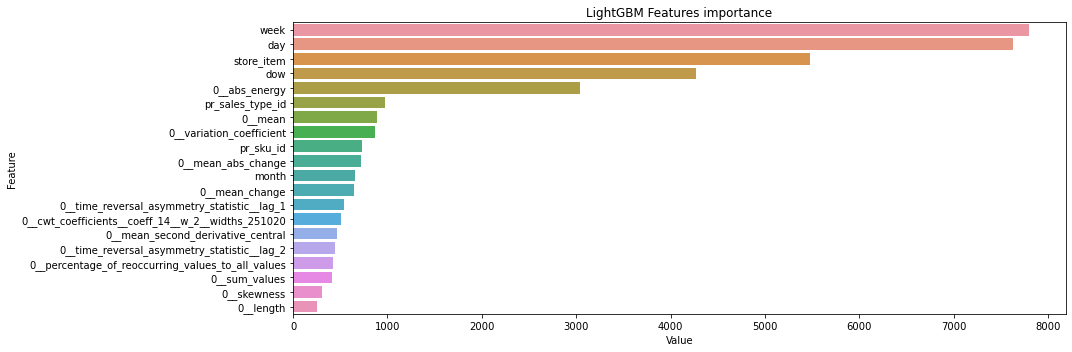

In [55]:
data=df_fresh
#cols_to_drop=['pr_sales_in_units', 'date', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']
cols_to_drop=['pr_sales_in_units', 'date']
cat_features=['store_item', 'pr_sku_id', 'st_id']

X_train = df_fresh.drop(cols_to_drop, axis=1)
y_train = df_fresh['pr_sales_in_units']
X_valid = valid.drop(cols_to_drop, axis=1)
y_valid = valid['pr_sales_in_units']

eval_set = [(X_valid, y_valid)]
print(end_train)
print(X_train.shape, X_valid.shape)
        
cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

for col in cat_features:
    X_train[col] = pd.Categorical(X_train[col])
    X_valid[col] = pd.Categorical(X_valid[col])

lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
lgbm_reg.fit(
                X_train, 
                y_train,        
                categorical_feature=cat_idx,
                eval_set=eval_set,
                early_stopping_rounds=200,
                verbose=100
            )
preds = lgbm_reg.predict(X_valid)
lgbm_wape = wape(y_valid, preds)
print(f"LGBM WAPE: {lgbm_wape}")

plotImp(lgbm_reg, X_train)

In [57]:
import pickle
pkl_filename = "fin_fresh_model_top20_feature_eff.pkl" 
with open(pkl_filename, 'wb') as file: 
    pickle.dump(lgbm_reg, file) 

In [56]:
#найдем список 20 лучших признаков
feature_imp = pd.DataFrame({'Value':lgbm_reg.feature_importances_,'Feature':X_train.columns})
feature_list=feature_imp.sort_values(by ='Value', ascending = False).head(20)['Feature'].to_list()
feature_list

['week',
 'day',
 'store_item',
 'dow',
 '0__abs_energy',
 'pr_sales_type_id',
 '0__mean',
 '0__variation_coefficient',
 'pr_sku_id',
 '0__mean_abs_change',
 'month',
 '0__mean_change',
 '0__time_reversal_asymmetry_statistic__lag_1',
 '0__cwt_coefficients__coeff_14__w_2__widths_251020',
 '0__mean_second_derivative_central',
 '0__time_reversal_asymmetry_statistic__lag_2',
 '0__percentage_of_reoccurring_values_to_all_values',
 '0__sum_values',
 '0__skewness',
 '0__length']

Результаты на датасете df_fin с 780 фичами сгенерированными EfficientFCParameters.<div>
        **Итерация 1.** <div>
* Фичи: Магазин-товар, магазин, флаг промо и то, что сгенерировал tsfresh (780+ фич).
* ВЭЙП: 0.4714141420531011
* Важное: 'store_item',
 'pr_sales_type_id',
 'pr_sku_id',
 'st_id',
 '0__abs_energy',
 '0__sum_values',
 '0__mean',
 '0__mean_abs_change',
 '0__mean_change',
 '0__variation_coefficient',
 '0__mean_second_derivative_central',
 '0__friedrich_coefficients__coeff_2__m_3__r_30',
 '0__length',
 '0__has_duplicate_min',
 '0__cwt_coefficients__coeff_14__w_2__widths_251020',
 '0__percentage_of_reoccurring_values_to_all_values',
 '0__skewness',
 '0__time_reversal_asymmetry_statistic__lag_1',
 '0__last_location_of_maximum',
 '0__time_reversal_asymmetry_statistic__lag_2' . <div>
    
**Итерация 2.** <div>
* Фичи: Важные фичи из первой итерации и календарные.
* ВЭЙП: 0.42339581524648934
* Важное: 'week',
 'day',
 'store_item',
 'dow',
 '0__abs_energy',
 'pr_sales_type_id',
 '0__mean',
 '0__variation_coefficient',
 'pr_sku_id',
 '0__mean_abs_change',
 'month',
 '0__mean_change',
 '0__time_reversal_asymmetry_statistic__lag_1',
 '0__cwt_coefficients__coeff_14__w_2__widths_251020',
 '0__mean_second_derivative_central',
 '0__time_reversal_asymmetry_statistic__lag_2',
 '0__percentage_of_reoccurring_values_to_all_values',
 '0__sum_values',
 '0__skewness',
 '0__length'. 

In [58]:
def objective(trial, data=df_fresh, cols_to_drop=['pr_sales_in_units', 'date'], cat_features=['store_item', 'pr_sku_id', 'st_id', 'dow']):
    
    train_x = df_fresh.drop(cols_to_drop, axis=1)
    train_y = train['pr_sales_in_units']
    test_x = valid.drop(cols_to_drop, axis=1)
    test_y = valid['pr_sales_in_units']

    cat_idx = [train_x.columns.get_loc(col) for col in cat_features]

    for col in cat_features:
        train_x[col] = pd.Categorical(train_x[col])
        test_x[col] = pd.Categorical(test_x[col])

    param = {
        'metric': 'mae', 
        'random_state': 26,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1)
    }
    model = lgbm.LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,categorical_feature=cat_idx,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=500)
    
    preds = model.predict(test_x)

    trial.set_user_attr(key="best_booster", value=model)
    
    return wape(test_y, preds)

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction='minimize'
    )
    study.optimize(objective, n_trials=10, callbacks=[callback])
    best_model=study.user_attrs["best_booster"]

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-10-08 17:39:36,633] A new study created in memory with name: no-name-05e15066-37c0-4001-982a-ddff756cc1a2


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.30000000000000004
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 3.3021
Early stopping, best iteration is:
[453]	valid_0's l1: 3.29408
Finished loading model, total used 453 iterations


[I 2023-10-08 17:40:27,370] Trial 0 finished with value: 0.4418487907936527 and parameters: {'reg_alpha': 2.0839856183547174, 'reg_lambda': 2.6874162320965134, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 220, 'min_child_samples': 287, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.4418487907936527.


Finished loading model, total used 453 iterations
Finished loading model, total used 453 iterations
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 3.17692
Early stopping, best iteration is:
[421]	valid_0's l1: 3.14958
Finished loading model, total used 421 iterations


[I 2023-10-08 17:44:11,993] Trial 1 finished with value: 0.4224670048539112 and parameters: {'reg_alpha': 0.0048855316801639575, 'reg_lambda': 0.031026053887039304, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 812, 'min_child_samples': 207, 'feature_fraction': 0.9}. Best is trial 1 with value: 0.4224670048539112.


Finished loading model, total used 421 iterations
Finished loading model, total used 421 iterations
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.2
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 3.32097
Early stopping, best iteration is:
[562]	valid_0's l1: 3.29102
Finished loading model, total used 562 iterations


[I 2023-10-08 17:46:49,761] Trial 2 finished with value: 0.4414385156065469 and parameters: {'reg_alpha': 0.17401515327169195, 'reg_lambda': 0.7061408359561203, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 821, 'min_child_samples': 138, 'feature_fraction': 0.2}. Best is trial 1 with value: 0.4224670048539112.


Finished loading model, total used 421 iterations
Finished loading model, total used 421 iterations
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 3.31773
[1000]	valid_0's l1: 3.2308
Early stopping, best iteration is:
[1222]	valid_0's l1: 3.22005
Finished loading model, total used 1222 iterations


[I 2023-10-08 17:49:21,224] Trial 3 finished with value: 0.4319191610804909 and parameters: {'reg_alpha': 0.0014404855152299301, 'reg_lambda': 1.4255091997070104, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 419, 'min_child_samples': 50, 'feature_fraction': 0.5}. Best is trial 1 with value: 0.4224670048539112.


Finished loading model, total used 421 iterations
Finished loading model, total used 421 iterations
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.8
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 3.6767
Early stopping, best iteration is:
[428]	valid_0's l1: 3.63488
Finished loading model, total used 428 iterations


[I 2023-10-08 17:50:07,016] Trial 4 finished with value: 0.48756137728958054 and parameters: {'reg_alpha': 7.991511466502917, 'reg_lambda': 0.0020123047545856283, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 13, 'min_child_samples': 235, 'feature_fraction': 0.8}. Best is trial 1 with value: 0.4224670048539112.


Finished loading model, total used 421 iterations
Finished loading model, total used 421 iterations
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.5
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 3.20471
[1000]	valid_0's l1: 3.15671
[1500]	valid_0's l1: 3.1225
[2000]	valid_0's l1: 3.09846
Early stopping, best iteration is:
[2116]	valid_0's l1: 3.09428
Finished loading model, total used 2116 iterations


[I 2023-10-08 18:04:19,109] Trial 5 finished with value: 0.4150493067337981 and parameters: {'reg_alpha': 0.0019936680430322606, 'reg_lambda': 3.363837034054286, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 713, 'min_child_samples': 211, 'feature_fraction': 0.5}. Best is trial 5 with value: 0.4150493067337981.


Finished loading model, total used 2116 iterations
Finished loading model, total used 2116 iterations
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.5
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 3.11456
Early stopping, best iteration is:
[643]	valid_0's l1: 3.0873
Finished loading model, total used 643 iterations


[I 2023-10-08 18:07:28,061] Trial 6 finished with value: 0.41411217901947295 and parameters: {'reg_alpha': 0.00949821637813171, 'reg_lambda': 0.33595813853679407, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 338, 'min_child_samples': 208, 'feature_fraction': 0.5}. Best is trial 6 with value: 0.41411217901947295.


Finished loading model, total used 643 iterations
Finished loading model, total used 643 iterations
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.30000000000000004
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 3.26642
[1000]	valid_0's l1: 3.20111
[1500]	valid_0's l1: 3.17782
[2000]	valid_0's l1: 3.16931
Early stopping, best iteration is:
[1946]	valid_0's l1: 3.16632
Finished loading model, total used 1946 iterations


[I 2023-10-08 18:10:15,900] Trial 7 finished with value: 0.42471113915550546 and parameters: {'reg_alpha': 0.02813302411528424, 'reg_lambda': 0.020369597431180893, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 425, 'min_child_samples': 13, 'feature_fraction': 0.30000000000000004}. Best is trial 6 with value: 0.41411217901947295.


Finished loading model, total used 643 iterations
Finished loading model, total used 643 iterations
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.2
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 3.69267
[1000]	valid_0's l1: 3.45329
[1500]	valid_0's l1: 3.38617
Early stopping, best iteration is:
[1848]	valid_0's l1: 3.36873
Finished loading model, total used 1848 iterations


[I 2023-10-08 18:12:06,637] Trial 8 finished with value: 0.45186120456170337 and parameters: {'reg_alpha': 0.002260109987987395, 'reg_lambda': 0.007614173284830198, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 55, 'min_child_samples': 180, 'feature_fraction': 0.2}. Best is trial 6 with value: 0.41411217901947295.


Finished loading model, total used 643 iterations
Finished loading model, total used 643 iterations
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.30000000000000004
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[285]	valid_0's l1: 3.40705
Finished loading model, total used 285 iterations


[I 2023-10-08 18:12:38,983] Trial 9 finished with value: 0.45700157114886936 and parameters: {'reg_alpha': 0.1133825109602319, 'reg_lambda': 0.02844903576003276, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 83, 'min_child_samples': 124, 'feature_fraction': 0.30000000000000004}. Best is trial 6 with value: 0.41411217901947295.


Finished loading model, total used 643 iterations
Finished loading model, total used 643 iterations
Finished loading model, total used 643 iterations
Finished loading model, total used 453 iterations
Finished loading model, total used 421 iterations
Finished loading model, total used 562 iterations
Finished loading model, total used 1222 iterations
Finished loading model, total used 428 iterations
Finished loading model, total used 2116 iterations
Finished loading model, total used 643 iterations
Finished loading model, total used 1946 iterations
Finished loading model, total used 1848 iterations
Finished loading model, total used 285 iterations
Number of finished trials: 10
Finished loading model, total used 643 iterations
Best trial: {'reg_alpha': 0.00949821637813171, 'reg_lambda': 0.33595813853679407, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 338, 'min_child_samples': 208, 'feature_fraction': 0.5}


LGBM WAPE: 0.41411217901947295


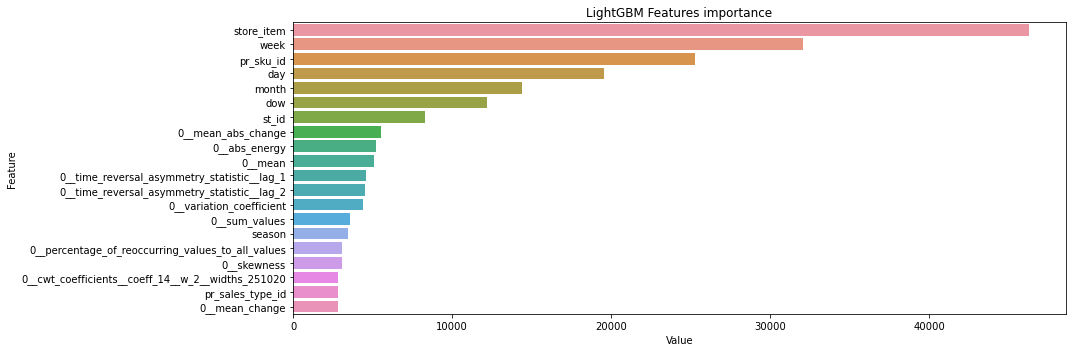

In [61]:
data=df_fresh
cols_to_drop=['pr_sales_in_units', 'date']
cat_features=['store_item', 'pr_sku_id', 'st_id', 'dow']

X_train = df_fresh.drop(cols_to_drop, axis=1)
y_train = df_fresh['pr_sales_in_units']
X_valid = valid.drop(cols_to_drop, axis=1)
y_valid = valid['pr_sales_in_units']

cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

for col in cat_features:
    X_train[col] = pd.Categorical(X_train[col])
    X_valid[col] = pd.Categorical(X_valid[col])

lgbm_reg = best_model
preds = lgbm_reg.predict(X_valid)
lgbm_wape = wape(y_valid, preds)
print(f"LGBM WAPE: {lgbm_wape}")

plotImp(lgbm_reg, X_train)

In [62]:
import pickle
pkl_filename = "fin_fresh_optuna_top20_feature_eff.pkl" 
with open(pkl_filename, 'wb') as file: 
    pickle.dump(lgbm_reg, file) 

In [ ]:
Best trial: {'reg_alpha': 0.00949821637813171, 'reg_lambda': 0.33595813853679407, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 338, 'min_child_samples': 208, 'feature_fraction': 0.5}

In [ ]:
# def lgbm_cross_val(cat_features, cols_to_drop, df=df_fresh, h=14, cv=5):
#     wapes = []
#     for i in range(cv):
#         end_train = df['date'].max() - pd.Timedelta(days=h*(i+1))
#         end_valid = df['date'].max() - pd.Timedelta(days=h*i)
#         train = df[df['date'] <= end_train]
#         valid = df[(df['date'] > end_train) & (df['date'] <= end_valid)]

#         X_train = train.drop(cols_to_drop, axis=1)
#         y_train = train['pr_sales_in_units']
#         X_valid = valid.drop(cols_to_drop, axis=1)
#         y_valid = valid['pr_sales_in_units']

#         eval_set = [(X_valid, y_valid)]
#         print(end_train, end_valid)
#         print(X_train.shape, X_valid.shape)

#         cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

#         for col in cat_features:
#             X_train[col] = pd.Categorical(X_train[col])
#             X_valid[col] = pd.Categorical(X_valid[col])


#         lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
#         lgbm_reg.fit(
#                 X_train, 
#                 y_train,        
#                 categorical_feature=cat_idx,
#                 eval_set=eval_set,
#                 early_stopping_rounds=200,
#                 verbose=100
#             )

#         preds = lgbm_reg.predict(X_valid)
#         lgbm_wape = wape(y_valid, preds)
        
#         plot_df = pd.DataFrame({'date': pd.date_range(start=(end_train+pd.Timedelta(days=1)), end=end_valid), 'y_true': y_valid[:h], 'y_pred': preds[:h]})
        
#         fig, ax = plt.subplots(figsize=(12, 3))
#         g = sns.lineplot(data=plot_df)
#         plt.title(f'CV step {i+1}')
#         plt.show()        
        
#         print(f"LGBM CV step {i+1} WAPE: {lgbm_wape}")
#         wapes.append(lgbm_wape)

        
#     plotImp(lgbm_reg, X_train)

#     return(wapes)

In [ ]:
# lgbm_wapes = lgbm_cross_val(df=df_fresh, cat_features=['store_item', 'pr_sku_id', 'st_id'],\
#             cols_to_drop=['pr_sales_in_units', 'date', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub'])

In [ ]:
# print(f'LGBM mean WAPE = {np.mean(lgbm_wapes)}')

Результаты на датасете df_fresh с 780 фичами сгенерированными EfficientFCParameters.<div>
 Итерация 1. 
* Фичи: Магазин-товар, магазин, флаг промо и то, что сгенерировал tsfresh (780+ фич).
* ВЭЙП: 0.5
* Важное: магазин-товар, товар, флаг промо, 0_sum_values, магазин, 0__fourier_entropy__bins_2, 0_median, 0_mean_abs_change, 0__mean, 0__abs_energy, 0__cwt_coefficients__coeff_0__w_5_widths_251020, 0__mean_change. <div>
    
    Итерация 2. <div>
* Фичи: Важные фичи из первой итерации и календарные.
* ВЭЙП: 0.4712452756340753
* Важное: week, dow, 0_sum_values, товар,0_median, 0_abs_energy, day/season практически не влияет. 

Результаты с 780 фичами сгенерированными EfficientFCParameters (датасет byproducts). <div>
    Итерация 1. 
* Фичи: Только то, что сгенерировал tsfresh.
* ВЭЙП: 0.5428495793143385
* Важное: товар, 0_sum_values, 0_abs_energy, 0_median, 0_agg_linear_trend_attr_intercept_chunk_len_50_f_agg_mean, 0_mean_change, 0_quantile_q_07, 0_mean_abs_change, 0_quantile_q_06, 0_fft_coefficient_attr_abs_coeff_97. <div>
    
    Итерация 2. <div>
* Фичи: Важные фичи из первой итерации и календарные.
* ВЭЙП: 0.44511336308301114
* Важное: week, dow, 0_sum_values, товар,0_median, 0_abs_energy, day/season практически не влияет. 

Результаты с лагами и MA.<div>
Итерация 1

* Фичи: товар, магазин, 21 лаг (Тлаг)
* ВЭЙП: 0.5387446485520166
* Важное: товар, Тлаг 1, магазин, Тлаги 14, 7, 2, 6, 12, 13, 5, 9

Итерация 2

* Фичи: товар, магазин, 21 лаг (Тлаг), 21 лаг (Млаг)
* ВЭЙП: 0.542979568453861
* Важное: товар, Тлаги 1, 14, 7, магазин, Тлаг 6, Млаги 6, 7, 13, 14
* Вывод: стало хуже. Пока оставим магазинные лаги, но когда фичей будет больше, попробуем их убрать

Итерация 3

* Фичи: товар, магазин, 21 лаг (Тлаг), 21 лаг (Млаг), календарные
* ВЭЙП: 0.5372880913031014
* Важное: товар, Тлаги 1, 14, магазин, день недели, Млаг 7, Тлаги 2, 7, Млаг 6, Тлаг 6, Млаг 13
* Вывод: метрика немного улучшилась. Календарные фичи нужны

Здесь сохраняется та же логика кросс-валидации, которую мы применяли для предыдущей модели: мы выделили в качестве валидационной выборки последние 14 дней, оставив все предшествующие данные в обучающей выборке. Для второго фолда кросс-валидации мы сдвинули валидационную выборку на две недели раньше, тем самым на 14 дней сократив обучающую. Таким образом мы в цикле последовательно формируем 5 фолдов кросс-валидации, обучаем на хронологически первых данных градиентный бустинг, валидируем его на последних 14 днях и оцениваем важность признаков в порядке от наиболее к наименее важным. По изменениям метрики и графику важности признаков мы оцениваем признаки, добавленные в данной итерации. Наблюдения за процессом записаны в ячейке под обучением

Наиболее важным представляется категориальный признак товар, затем его продажи вчера и позавчера. Это кажется логичным: прогноз основывается на том, как товар обычно продается, как продавался в последние дни. Важны лаги, кратные 7, что указывает на сильную недельную сезонность. На самом деле это даже может быть проблемой: когда мы смотрим на графики прогнозов нашей модели, мы мало что видим, кроме двух небольших пиков в выходные. Продажи магазина кажутся менее значимыми, чем продажи товара по всем магазинам, однако вчерашние продажи магазина и продажи неделю назад все же вошли в топ. Из календарных признаков важны день месяца и номер недели - есть тренд и месячная сезонность

### Forecasting

In [ ]:
#get lines from submission form
updated_sub = pd.read_csv('updated_sub.csv')
updated_sub['date'] = pd.to_datetime(updated_sub['date']).dt.normalize()
updated_sub['store_item'] = updated_sub['st_id'].str.cat(updated_sub['pr_sku_id'], sep='-')
updated_sub.head()

In [ ]:
#take only those lines we didn't fill in the previous part
nonflagman_sub = updated_sub[updated_sub['target'].isna()]
nonflagman_sub.shape

In [ ]:
#make sure there are 14-days forecast periods for each of item-store pairs
nonflagman_sub['store_item'].nunique() * 14

In [ ]:
def preprocess_test_by_sku(pred_with_history):    
    #index needs to be reset, as for non-first lines in a forecast they are equal
    pred_with_history = pred_with_history.reset_index(drop=True)

    #add lags - sku
    pred_with_history[['sku_lag_' + str(n) for n in range(1, 22)]] = pred_with_history[['sku_lag_' + str(n) for n in range(1, 22)]].fillna(method='ffill')
    pred_with_history[['sku_lag_' + str(n) for n in range(1, 22)]] = pred_with_history[['sku_lag_' + str(n) for n in range(1, 22)]].shift(1, axis=1)
    pred_with_history.loc[pred_with_history.index[-1], 'sku_lag_1'] = pred_with_history.loc[pred_with_history.index[0], 'sku']

    #add features of day-of-week, day-of-month, week, month, season
    pred_with_history['dow'] = pred_with_history['date'].dt.dayofweek
    pred_with_history['day'] = pred_with_history['date'].dt.day
    pred_with_history['week'] = pred_with_history['date'].dt.isocalendar().week.astype('int32')
    pred_with_history['month'] = pred_with_history['date'].dt.month
    pred_with_history['season'] = pred_with_history['date'].dt.quarter    
    
    #drop upper row
    pred_with_history = pred_with_history.drop(pred_with_history.index[0], axis=0)    

    return(pred_with_history)

In [ ]:
def preprocess_test_by_store(pred_with_history):    
    #index needs to be reset, as for non-first lines in a forecast they are equal
    pred_with_history = pred_with_history.reset_index(drop=True)

    #add lags - store
    pred_with_history[['store_lag_' + str(n) for n in range(1, 22)]] = pred_with_history[['store_lag_' + str(n) for n in range(1, 22)]].fillna(method='ffill')
    pred_with_history[['store_lag_' + str(n) for n in range(1, 22)]] = pred_with_history[['store_lag_' + str(n) for n in range(1, 22)]].shift(1, axis=1)
    pred_with_history.loc[pred_with_history.index[-1], 'store_lag_1'] = pred_with_history.loc[pred_with_history.index[0], 'store']
    
    #drop upper row
    pred_with_history = pred_with_history.drop(pred_with_history.index[0], axis=0)    

    return(pred_with_history)

In [ ]:
#this is what we'll get as input
nonflagman_sub = nonflagman_sub.drop('store_item', axis=1)
first_pred = nonflagman_sub[nonflagman_sub['date'] == nonflagman_sub['date'].min()].head(1)
first_pred

In [ ]:
def make_forecast_for_sample_row(line_from_submission, h=14):
    forecast = pd.DataFrame()
    row = line_from_submission.copy()
    start_date = row['date']
    
    for i in range(h):
        row['date'] = start_date + pd.Timedelta(days=1*i)
        lower_row = row.copy()

        #if first line take lags from the last line of train. otherwise from previous predicted line
        #first match sku to get sku lags
        if i == 0:
            last_train_date = with_store_lags['date'].max()
            upper_row = with_store_lags[(with_store_lags['pr_sku_id'] == lower_row['pr_sku_id'].item()) & 
                                        (with_store_lags['date'] == last_train_date)].head(1)
        else:
            upper_row = last_preprocessed
        
        #glue two lines together, the full and the empty that needs features to be added
        pred_with_history = pd.concat([upper_row, lower_row])        
        sku_preprocessed = preprocess_test_by_sku(pred_with_history)

        #now match store to get store lags
        if i == 0:
            last_train_date = with_store_lags['date'].max()
            upper_row = with_store_lags[(with_store_lags['st_id'] == lower_row['st_id'].item()) & 
                                        (with_store_lags['date'] == last_train_date)].head(1)
        else:
            upper_row = last_preprocessed
        
        #glue two lines together, the full and the empty that needs features to be added
        pred_with_history = pd.concat([upper_row, sku_preprocessed])        
        last_preprocessed = preprocess_test_by_store(pred_with_history)
        
        #drop columns before model
        X_test = last_preprocessed.drop(['date', 'sold', 'sku', 'store', 'target'], axis=1)

        #fix categorical
        for col in cat_features:
            X_test[col] = pd.Categorical(X_test[col])
            
        pred = lgbm_reg.predict(X_test)

        #prediction becomes "fact" of the day we forecast to become lag_1 for the next day. also it goes to forecast table as target
        last_preprocessed['sold'] = round(pred.item())
        row['target'] = round(pred.item())
        
        forecast = pd.concat([forecast, row])
        
    return forecast

make_forecast_for_sample_row(first_pred)

In [ ]:
#lets fill submission file with forecasts. na sum shows how many values are left
updated_sub.isna().sum()

In [ ]:
#here are pairs we're going to predict with this model
nonflagman_sub = nonflagman_sub.groupby(['st_id', 'pr_sku_id'])['date'].min().reset_index()
nonflagman_sub.head()

In [ ]:
nonflagman_sub.shape

In [ ]:
common_forecast = pd.DataFrame()
for index, row in nonflagman_sub.iterrows():
    try:
        forecast = make_forecast_for_sample_row(pd.DataFrame({'st_id': row['st_id'], 'pr_sku_id': row['pr_sku_id'], 'date': row['date'], 'target': np.nan}, index=[0]))    
        common_forecast = pd.concat([common_forecast, forecast])
    except:
        continue
    

In [ ]:
#check that there are 14 days of forecast for each pair of 2341
common_forecast.date.value_counts()

In [ ]:
#update submission
updated_sub = updated_sub.merge(common_forecast, on=['st_id', 'pr_sku_id', 'date'], how='left')
updated_sub.isna().sum()

In [ ]:
#return to original columns
new_updated_sub = updated_sub.copy()
new_updated_sub['isna_sum'] = new_updated_sub.isna().sum(axis=1)
new_updated_sub['target_x'] = new_updated_sub[['target_x', 'target_y']].sum(axis=1)
new_updated_sub = new_updated_sub.rename(columns={'target_x': 'target'}).drop(['target_y', 'store_item'], axis=1)
new_updated_sub['target'] = new_updated_sub.apply(lambda x: np.nan if x['isna_sum'] == 2 else x['target'], axis=1)
new_updated_sub.isna().sum()

У нас осталось достаточно много незаполненных строк. Это строки, попавшие при прогнозе в исключение - для товаров не нашлись данные в последний день обучающей выборки, 2023-07-18. Подтянем для них временные ряды, ранее заполненные нулями. Для этого необходимо изменить функцию прогноза

In [ ]:
def make_last_forecast(line_from_submission, h=14):
    forecast = pd.DataFrame()
    row = line_from_submission.copy()
    start_date = row['date']
    
    for i in range(h):
        row['date'] = start_date + pd.Timedelta(days=1*i)
        lower_row = row.copy()

        #this is what we change. look for lags not in train dataset, but in byproduct where we filled missing days with zeros
        if i == 0:
            last_train_date = with_store_lags['date'].max()
            upper_row = byproduct[(byproduct['pr_sku_id'] == lower_row['pr_sku_id'].item()) & 
                                        (byproduct['date'] == last_train_date)].head(1)
        else:
            upper_row = last_preprocessed
        
        #glue two lines together, the full and the empty that needs features to be added
        pred_with_history = pd.concat([upper_row, lower_row])        
        sku_preprocessed = preprocess_test_by_sku(pred_with_history)

        #now match store to get store lags
        if i == 0:
            last_train_date = with_store_lags['date'].max()
            upper_row = with_store_lags[(with_store_lags['st_id'] == lower_row['st_id'].item()) & 
                                        (with_store_lags['date'] == last_train_date)].head(1)
        else:
            upper_row = last_preprocessed
        
        #glue two lines together, the full and the empty that needs features to be added
        pred_with_history = pd.concat([upper_row, sku_preprocessed])        
        last_preprocessed = preprocess_test_by_store(pred_with_history)
        
        #drop columns before model
        X_test = last_preprocessed.drop(['date', 'sold', 'sku', 'store', 'target'], axis=1)

        #fix categorical
        for col in cat_features:
            X_test[col] = pd.Categorical(X_test[col])
            
        pred = lgbm_reg.predict(X_test)

        #prediction becomes "fact" of the day we forecast to become lag_1 for the next day. also it goes to forecast table as target
        last_preprocessed['sold'] = round(pred.item())
        row['target'] = round(pred.item())
        
        forecast = pd.concat([forecast, row])
        
    return forecast

In [ ]:
#form dataset for which forecast is not filled
rare_sku_sub = new_updated_sub[new_updated_sub['target'].isna()]
rare_sku_sub = rare_sku_sub.groupby(['st_id', 'pr_sku_id'])['date'].min().reset_index()
rare_sku_sub.head()

In [ ]:
rare_sku_sub.shape, 8092 / 14

In [ ]:
common_forecast = pd.DataFrame()
for index, row in rare_sku_sub.iterrows():
    try:
        forecast = make_last_forecast(pd.DataFrame({'st_id': row['st_id'], 'pr_sku_id': row['pr_sku_id'], 'date': row['date'], 'target': np.nan}, index=[0]))    
        common_forecast = pd.concat([common_forecast, forecast])    
    except:
        continue

In [ ]:
#check that there are 14 days of forecast for each pair of remaining 578
common_forecast.date.value_counts()

In [ ]:
#update submission
new_updated_sub = new_updated_sub.merge(common_forecast, on=['st_id', 'pr_sku_id', 'date'], how='left')
new_updated_sub.isna().sum()

In [ ]:
#return to original columns
last_updated_sub = new_updated_sub.copy()
last_updated_sub['isna_sum'] = last_updated_sub.isna().sum(axis=1)
last_updated_sub['target_x'] = last_updated_sub[['target_x', 'target_y']].sum(axis=1)
last_updated_sub = last_updated_sub.rename(columns={'target_x': 'target'}).drop(['target_y'], axis=1)
last_updated_sub['target'] = last_updated_sub.apply(lambda x: np.nan if x['isna_sum'] == 2 else x['target'], axis=1)
last_updated_sub.isna().sum()

In [ ]:
last_updated_sub = last_updated_sub.fillna(0).drop('isna_sum', axis=1)
last_updated_sub.isna().sum()

In [ ]:
#save to csv
last_updated_sub.to_csv('submission.csv', index=False)

Эту часть мы планируем улучшить, однако в целях облегчения ревью опишем, что происходит в ней сейчас:

1) мы выделяем в датасет nonflagman_sub пары товар-магазин, для которых создана эта модель модель, не вошедшие в топ и с разреженными временными рядами

2) для каждой строки из тестовой выборки необходимо создать фичи по образу обучающей выборки. Здесь есть отличие от предыдущей модели. К каждой строке мы отдельно подбираем данные по товару и по магазину в предыдущий день (не по паре товар-магазин, как в первой модели). Если речь идет о первом дне прогноза, данные берем из последнего дня обучающей выборки. Для дней прогноза со 2 по 14 основанием для создания лагов и скользящих средних является предыдущая строка прогноза. Предобработка столбцов задана в функции preprocess_test. Функция make_forecast_for_sample_row принимает на вход строку из списка целевых пар и выдает датафрейм прогноза на 14 дней

3) мы итерируемся по списку пар товар-магазин и, выводя прогноз для каждой из них, конкатенируем их в единый датафрейм

4) соединяем датафрейм submission с полученным прогнозом, заполняя часть значений в столбце target

5) если в первой модели мы на этом закончили, то здесь мы сталкиваемся с проблемой: у нас остались незаполненные строки прогноза. Это связано с тем, что не все фичи для тестовых строк удалось заполнить. Данные о продажах по магазину за вчера есть для всех пар, чего нельзя сказать о данных по товару. Некоторые товары не продавались в последний день обучающего датасета ни в одном магазине. Для таких случаев мы обращаемся к ранее созданному датасету byproduct, в котором разреженные временные ряды заполнены нулями. Возможно, нам следует сделать это сразу, сняв необходимость этой второй итерации

6) однако и после этого информация о порядка 100 товаров не была найдена - проверяем в исходном датасете sales: это товары, которые не продавались никогда и нигде. Прогноз продаж новых товаров - это отдельная сложная задача, вернемся к ней позже. Пока для простоты будем считать, что если что-то никогда не пользовалось спросом, то нет оснований полагать, что завтра вдруг начнем, и заполним эти строки нулями.

### to do

* закончить процесс формирования признаков для второй модели

* экспериментировать с разбивкой второй модели по кластерам

* попробовать другие алгоритмы ML, кроме градиентного бустинга

* использовать модели типа Аримы/Профета для прогноза цены вместо заглушки

* проработать проблему прогнозирования спроса на новые товары

* сделать кросс-валидацию 14-шаговой в соответствии с алгоритмом прогнозирования

* рассмотреть варианты рефакторинга алгоритма прогнозирования

* упаковать полученную модель (модели) в docker контейнер